In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import ttk

In [24]:
food_data = pd.read_csv("C:\\Users\\mithu\\Desktop\\VIT Projects\\III year\\XAI\\Food-Recommendation-System-main\\food-dataset-extended-2.csv", encoding="utf-8")

In [25]:
rating_columns = ["spice level", "sweet level", "sour level", "salt level", "bitter level"]
food_data[rating_columns] = food_data[rating_columns] / 10.0

ratings = food_data[rating_columns].mean(axis=1).values
dishes = np.arange(len(food_data)) 

X_train, X_test, y_train, y_test = train_test_split(dishes, ratings, test_size=0.2, random_state=42)

dish_input = Input(shape=(1,), name="dish_input")
dish_embedding = Embedding(input_dim=len(food_data), output_dim=16, name="dish_embedding")(dish_input)
dish_embedding = Flatten()(dish_embedding)

x = Dense(64, activation='relu')(dish_embedding)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)

output = Dense(1, activation='sigmoid', name="output_layer")(x)

ncf_model = Model(inputs=dish_input, outputs=output)
ncf_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
ncf_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
17/17 [==============================] - 1s 13ms/step - loss: 0.0267 - mae: 0.1334 - val_loss: 0.0227 - val_mae: 0.1222
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 0.0248 - mae: 0.1271 - val_loss: 0.0218 - val_mae: 0.1190
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 0.0236 - mae: 0.1216 - val_loss: 0.0219 - val_mae: 0.1190
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0230 - mae: 0.1182 - val_loss: 0.0221 - val_mae: 0.1196
Epoch 5/10
17/17 [==============================] - 0s 4ms/step - loss: 0.0211 - mae: 0.1113 - val_loss: 0.0226 - val_mae: 0.1210
Epoch 6/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0180 - mae: 0.0969 - val_loss: 0.0240 - val_mae: 0.1253
Epoch 7/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0763 - val_loss: 0.0271 - val_mae: 0.1348
Epoch 8/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0082 - mae: 0.0

2/2 [==============================] - 0s 4ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 2/10 [00:00<00:00, 13.54it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 4/10 [00:00<00:00, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 6/10 [00:00<00:00,  9.87it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 8/10 [00:00<00:00, 11.29it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 10/10 [00:00<00:00, 11.93it/s]


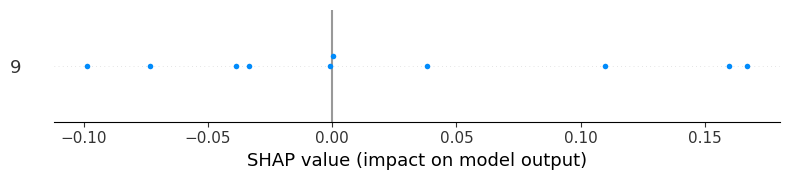

In [ ]:
import shap
def model_predict(dish_indices):
    return ncf_model.predict(dish_indices).flatten()

explainer = shap.KernelExplainer(model_predict, np.expand_dims(X_train[:50], axis=1))

shap_values = explainer.shap_values(np.expand_dims(X_test[:10], axis=1))
shap.summary_plot(shap_values, X_test[:10])





In [28]:
def recommend_dishes():
    cuisine = cuisine_var.get().strip().lower()
    taste = taste_var.get().strip().lower()
    temperature = temperature_var.get().strip().lower()
    spice_level = spice_var.get()
    sweet_level = sweet_var.get()
    salt_level = salt_var.get()
    sour_level = sour_var.get()
    bitter_level = bitter_var.get()
    
    if not cuisine and not taste and not temperature and spice_level == 0 and sweet_level == 0 and salt_level == 0 and sour_level == 0 and bitter_level == 0:
        result_label.config(text="Please provide at least one preference for better recommendations!")
        return

    user_prefs = {
        "cuisine": cuisine,
        "taste": taste,
        "temperature": temperature,
        "ratings": np.array([spice_level, sweet_level, salt_level, sour_level, bitter_level]).mean() / 10.0
    }
    
    filtered_data = food_data[
        (food_data['Cuisine'].str.lower() == user_prefs['cuisine']) &
        (food_data['taste'].str.lower() == user_prefs['taste']) &
        (food_data['temperature'].str.lower() == user_prefs['temperature'])
    ]

    if filtered_data.empty:
        result_label.config(text="No exact matches found. Showing top-rated dishes instead.")
        filtered_data = food_data

    dish_indices = np.arange(len(filtered_data))
    predicted_scores = ncf_model.predict(dish_indices)
    top_n_indices = np.argsort(predicted_scores.flatten())[::-1][:5]

    recommended_dishes = []
    
    for idx in top_n_indices:
        dish_name = filtered_data.iloc[idx]['Dish name']
        dish_cuisine = filtered_data.iloc[idx]['Cuisine']
        dish_taste = filtered_data.iloc[idx]['taste']
        dish_temperature = filtered_data.iloc[idx]['temperature']

        explanation = f"{dish_name} was recommended because it matches your preference for {dish_cuisine} cuisine with a {dish_taste} taste and served {dish_temperature}."
        recommended_dishes.append(explanation)

    result_label.config(text="Top 5 Recommended Dishes:\n" + "\n\n".join(recommended_dishes))


In [ ]:


root = tk.Tk()
root.title("Food Recommendation System")

cuisine_var = tk.StringVar()
taste_var = tk.StringVar()
temperature_var = tk.StringVar()
spice_var = tk.IntVar()
sweet_var = tk.IntVar()
salt_var = tk.IntVar()
sour_var = tk.IntVar()
bitter_var = tk.IntVar()

cuisines = ["Indian", "Chinese", "American"]
tastes = ["Sweet", "Sour", "Bitter","Spicy"]
temperatures = ["Hot", "Cold"]

tk.Label(root, text="Cuisine:").pack()
ttk.Combobox(root, textvariable=cuisine_var, values=cuisines).pack()

tk.Label(root, text="Taste:").pack()
ttk.Combobox(root, textvariable=taste_var, values=tastes).pack()

tk.Label(root, text="Temperature:").pack()
ttk.Combobox(root, textvariable=temperature_var, values=temperatures).pack()

tk.Label(root, text="Spice Level (0-10):").pack()
tk.Scale(root, from_=0, to=10, orient=tk.HORIZONTAL, variable=spice_var).pack()

tk.Label(root, text="Sweet Level (0-10):").pack()
tk.Scale(root, from_=0, to=10, orient=tk.HORIZONTAL, variable=sweet_var).pack()

tk.Label(root, text="Salt Level (0-10):").pack()
tk.Scale(root, from_=0, to=10, orient=tk.HORIZONTAL, variable=salt_var).pack()

tk.Label(root, text="Sour Level (0-10):").pack()
tk.Scale(root, from_=0, to=10, orient=tk.HORIZONTAL, variable=sour_var).pack()

tk.Label(root, text="Bitter Level (0-10):").pack()
tk.Scale(root, from_=0, to=10, orient=tk.HORIZONTAL, variable=bitter_var).pack()

tk.Button(root, text="Get Recommendations", command=recommend_dishes).pack()

result_label = tk.Label(root, text="")
result_label.pack()
root.geometry("500x600") 
root.mainloop()


2/2 [==============================] - 0s 3ms/step
